# Start


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
trajectories_db = np.load('/Users/henryschnieders/Documents/Research/My_Data/pixel_trajectories_20250603_193847.npz', allow_pickle=True)

# Signal Process Alter Definition

In [2]:
fps = 30



# Load the .npy file
# Replace 'your_file.npy' with the actual path to your .npy file

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
#  Helper: FFT-based HR estimator (unchanged)
# -------------------------------------------------------------
def complex_mag(x):
    return np.abs(x)

def signal_process_alter(pix_intensity, fps, num = 5):
    sampling_rate = fps
    lowcut_heart, highcut_heart = 0.5, 4.0

    N = len(pix_intensity)
    freqs = np.fft.fftfreq(N, d=1.0 / sampling_rate)
    coefs = np.fft.fft(pix_intensity)

    keep = (np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart)
    coefs, freqs = coefs[keep], freqs[keep]

    idx = np.argsort(complex_mag(coefs))[-num:]
    coefs, freqs = coefs[idx], freqs[idx]

    bpm = np.average(np.abs(freqs), weights=complex_mag(coefs)) * 60
    return bpm, freqs

# -------------------------------------------------------------
#  NEW: process the trajectories DB
# -------------------------------------------------------------
def process_fb_trajectories(trajectories_db, fps=30):
    """
    Build per-region signals from the FB-validated pixel tracks.

    Returns
    -------
    region_signals : list[5] of 1-D np.ndarray  (avg intensity per frame)
    motion_signals : list[5] of 1-D np.ndarray  (same as above for demo)
    id_map         : list[dict]  length 5; maps pixel-ID → column index
    """
    n_regions = 5
    n_frames  = len(trajectories_db[0]['rgb'])            # all tracks full-length

    # --- organise by region -------------------------------------------------
    region_tracks = [[] for _ in range(n_regions)]        # list of signals
    id_map        = [{}  for _ in range(n_regions)]       # pixel-ID → idx

    for tr in trajectories_db:
        r   = tr['region']
        pid = f"x{tr['x0']}_y{tr['y0']}"
        rgb = np.asarray(tr['rgb'], np.uint8)             # (T,3)
        gray = (0.114*rgb[:,0] + 0.587*rgb[:,1] + 0.299*rgb[:,2]).astype(np.float32)
        id_map[r][pid] = len(region_tracks[r])            # save column index
        region_tracks[r].append(gray)

    # pad into 2-D arrays region × pixel × frame
    region_signals, motion_signals = [], []
    for r in range(n_regions):
        if region_tracks[r]:
            M = np.stack(region_tracks[r], axis=0)        # (P,T)
            region_mean = M.mean(axis=0)
            region_signals.append(region_mean)
            # "motion": per-frame mean absolute diff of all pixel traces
            motion = np.mean(np.abs(np.diff(M, axis=1)), axis=0)
            motion = np.insert(motion, 0, motion[0])      # same length as frames
            motion_signals.append(motion)
        else:                                             # no tracks survived
            region_signals.append(np.full(n_frames, np.nan))
            motion_signals.append(np.full(n_frames, np.nan))

    return [np.asarray(s) for s in region_signals], \
           [np.asarray(m) for m in motion_signals], \
           id_map

# -------------------------------------------------------------
#  Driver
# # -------------------------------------------------------------
# def main():
#     fps = 30
#     traj_db = np.load('/Users/henryschnieders/Documents/Research/My_Data/pixel_trajectories_20250603_193847.npz',
#                       allow_pickle=True)['trajectories'].tolist()

#     region_signals, motion_signals, id_map = process_fb_trajectories(traj_db, fps)

#     # --- Heart-rate estimate per region ------------------------------------
#     region_heart_rates = []
#     for sig in region_signals:
#         ok = ~np.isnan(sig)
#         bpm, _ = signal_process_alter(sig[ok], fps) if ok.any() else (np.nan, [])
#         region_heart_rates.append(bpm)

#     # --- Plot 1: motion-like signal ----------------------------------------
#     plt.figure(figsize=(12, 10))
#     for r, mot in enumerate(motion_signals):
#         plt.subplot(5, 1, r+1)
#         plt.plot(mot, label=f"Region {r+1} motion")
#         plt.ylabel("Δ Intensity")
#         plt.grid(True)
#         plt.legend(loc="upper right")
#         if r == 4:
#             plt.xlabel("Frame")
#     plt.suptitle("Per-region motion (mean |ΔI|)")
#     plt.tight_layout(rect=[0, 0, 1, 0.96])

#     # --- Plot 2: average intensity traces ----------------------------------
#     plt.figure(figsize=(12, 10))
#     for r, sig in enumerate(region_signals):
#         plt.subplot(5, 1, r+1)
#         plt.plot(sig, label=f"Region {r+1}  (HR ≈ {region_heart_rates[r]:.1f} BPM)")
#         plt.ylabel("Gray")
#         plt.grid(True)
#         plt.legend(loc="upper right")
#         if r == 4:
#             plt.xlabel("Frame")
#     plt.suptitle("Average pixel intensity per face region")
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()

#     # --- example: look up a specific pixel track ---------------------------
#     pid_example = "x250_y180"          # put any x0_y0 here
#     for r in range(5):
#         if pid_example in id_map[r]:
#             col = id_map[r][pid_example]
#             print(f"Pixel {pid_example} is column {col} in region {r+1}")
#             break
#     else:
#         print("Pixel ID not found among surviving tracks.")

# if __name__ == "__main__":
#     main()


In [ ]:
#looks like artefacts at the beginning and end of the recording!

# Further Video Diagnostics

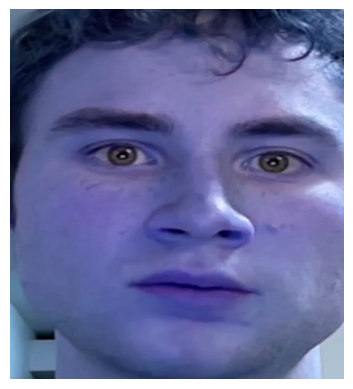

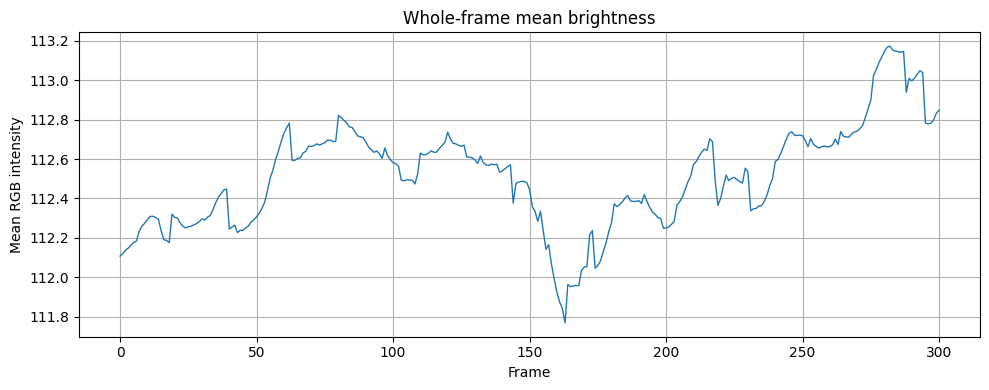

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------------
# 0.  point to your file
# -------------------------------------------------
fn = Path("/Users/henryschnieders/Documents/Research/My_Data/new_6_9_wholeface.npy")           # <-- change this



# -------------------------------------------------
# 1.  load the list of frames
# -------------------------------------------------
raw = np.load(fn, allow_pickle=True)            # object-array

img = raw[0]

plt.imshow(img)
plt.axis('off')
plt.show()

raw = raw[:]
frames = raw.tolist() if isinstance(raw, np.ndarray) else raw



# sanity-check: make sure every element really is an image
for idx, f in enumerate(frames):
    if not (isinstance(f, np.ndarray) and f.ndim == 3):
        raise ValueError(f"Item {idx} is not an H×W×C image")

# -------------------------------------------------
# 2-A.  QUICK way – compute the mean one frame at a time
# -------------------------------------------------
frame_mean = np.array([f.mean(dtype=np.float64) for f in frames])

# -------------------------------------------------
# 2-B.  (optional) STACK into a 4-D cube first
#        – only works if all frames share the same shape
# -------------------------------------------------
# H, W, C = frames[0].shape
# video   = np.stack(frames, axis=0)             # (T, H, W, C)
# frame_mean = video.mean(axis=(1, 2, 3), dtype=np.float64)

# -------------------------------------------------
# 3.  visualise
# -------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(frame_mean, lw=1)
plt.xlabel("Frame")
plt.ylabel("Mean RGB intensity")
plt.title("Whole-frame mean brightness")
plt.grid(True)
plt.tight_layout()
plt.show()


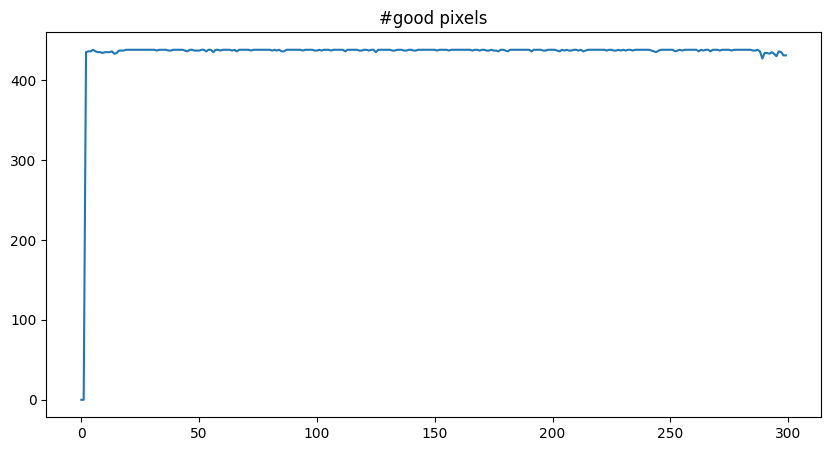

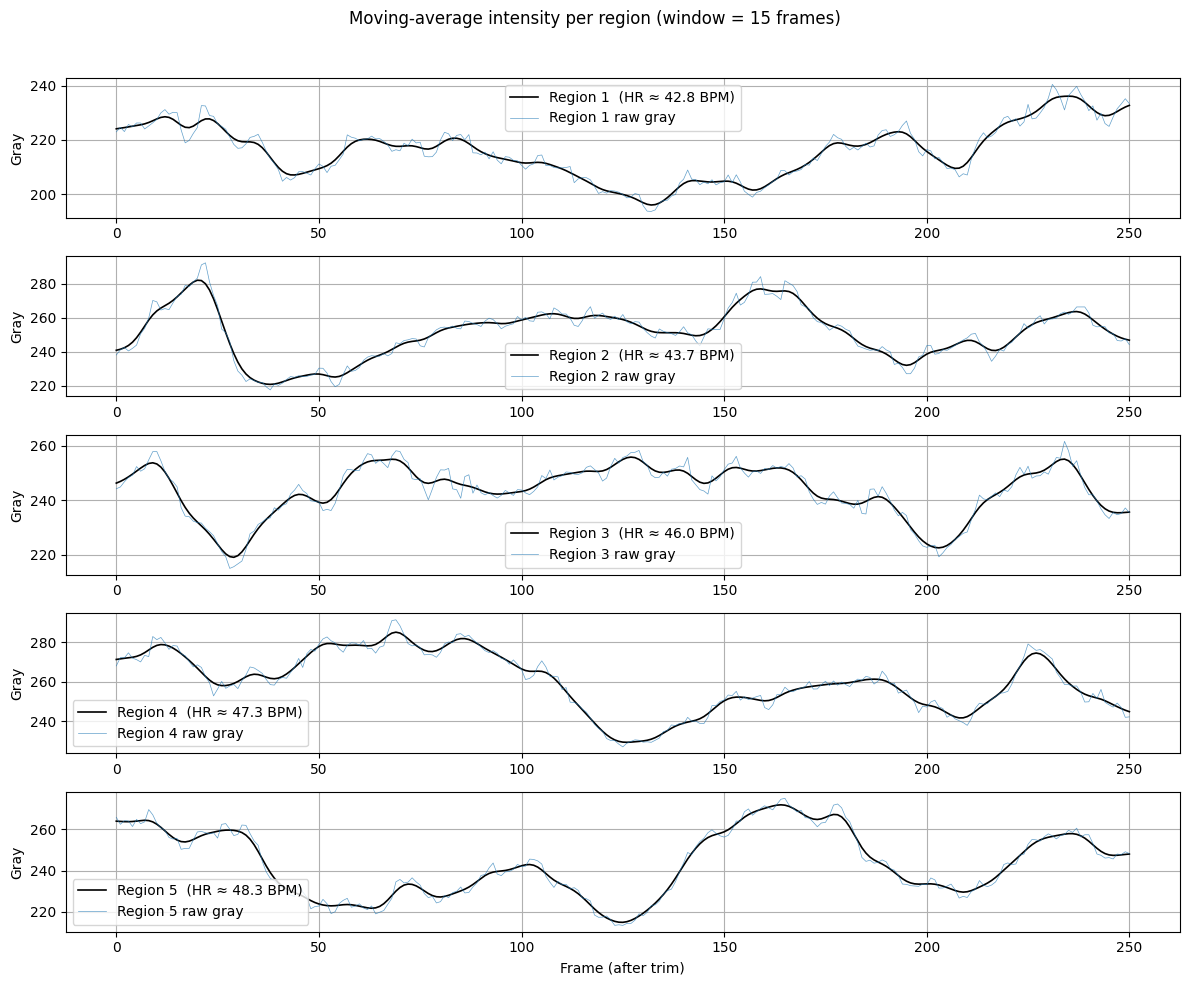

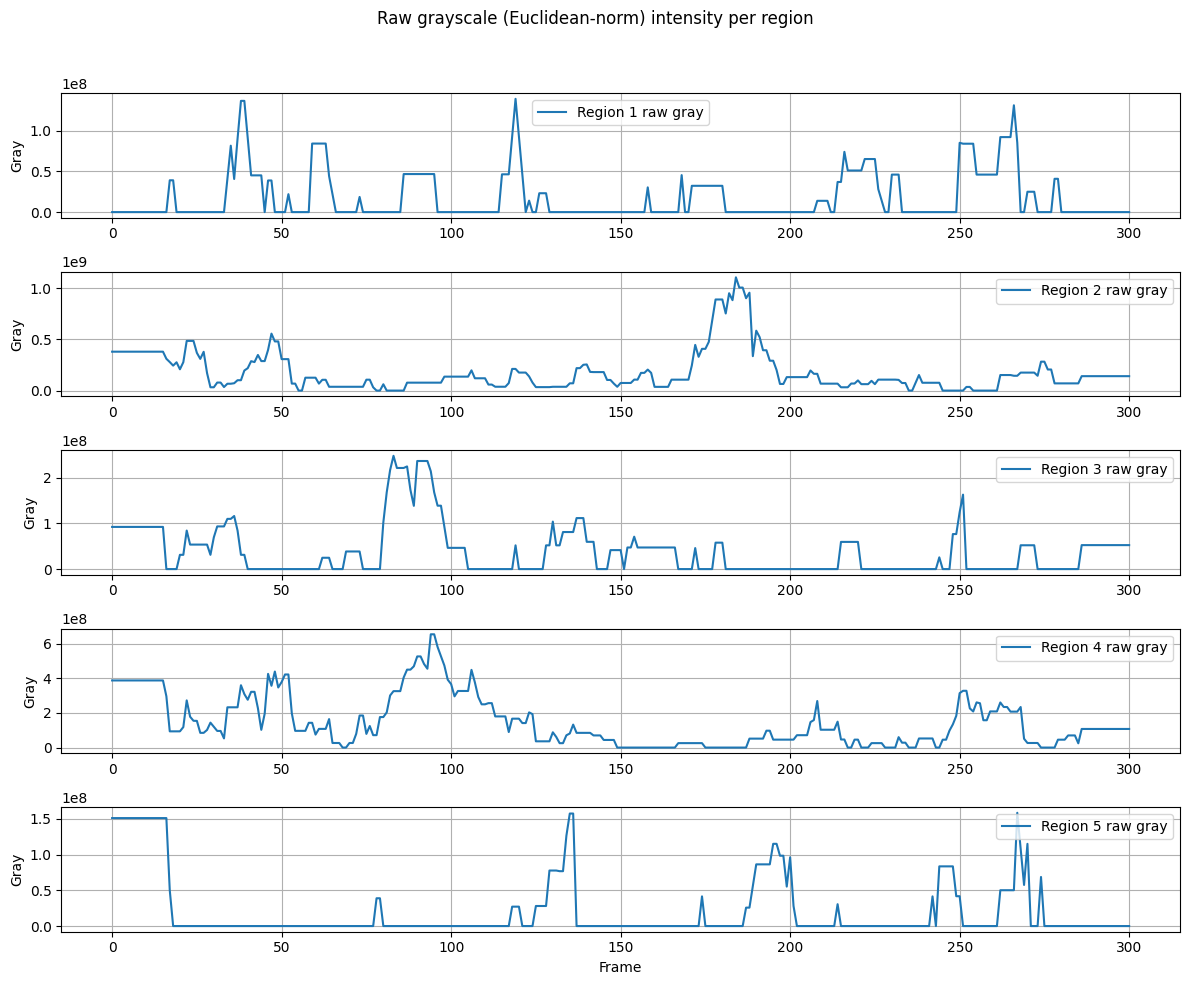

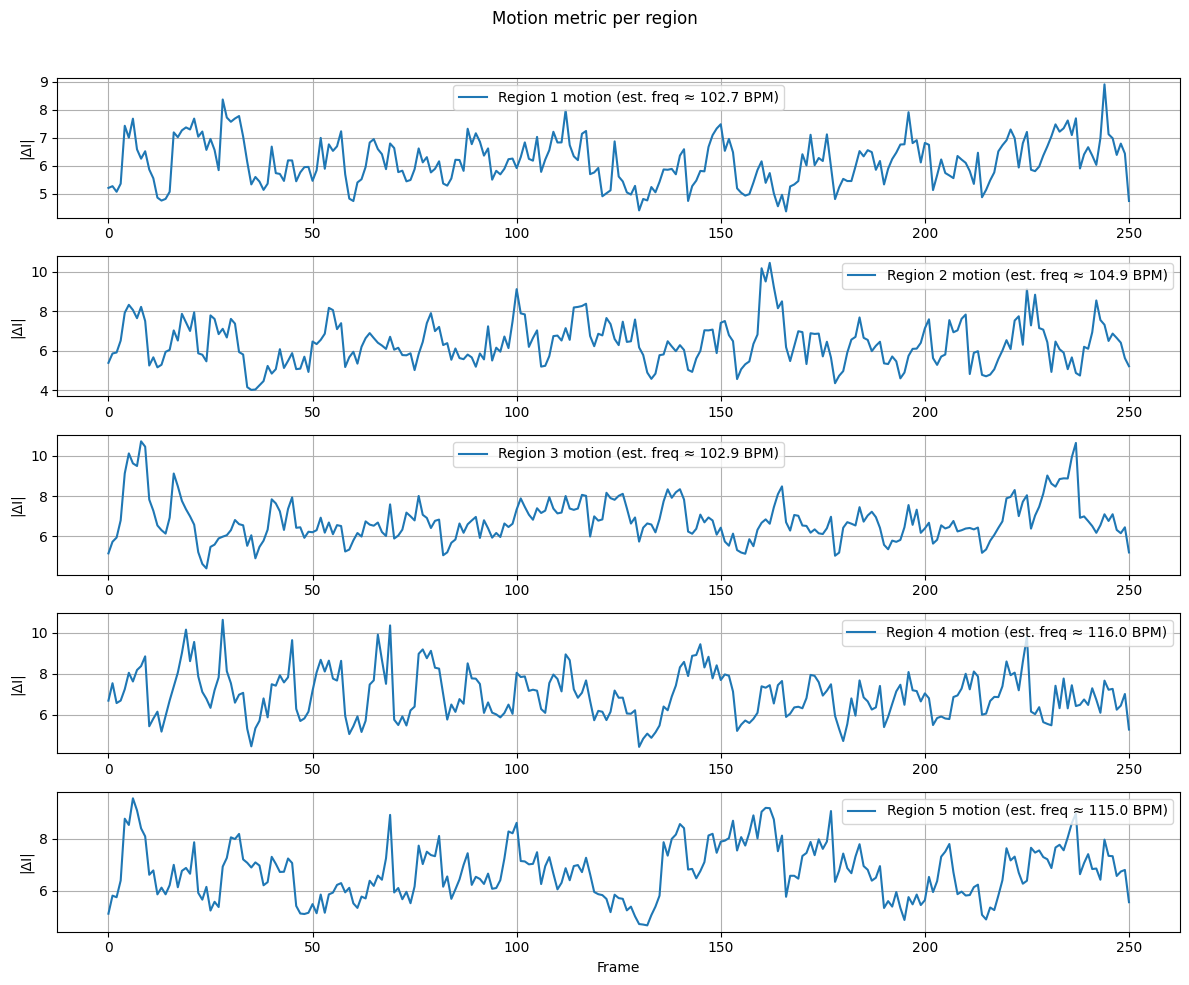

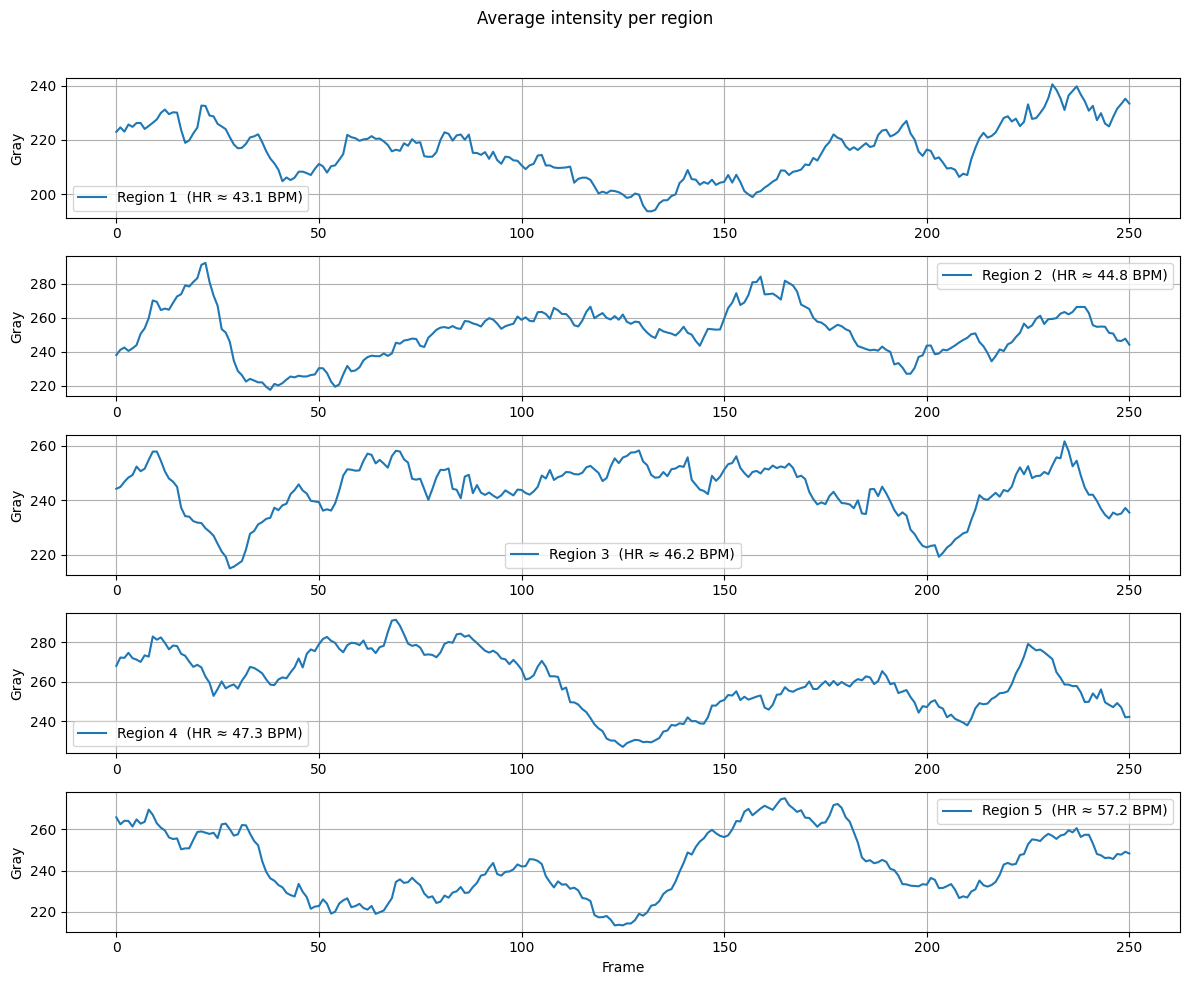

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# --------------------- configurable ---------------------
phi_tol      = 0.99         # cosine threshold
fps          = 30            # frames per second
n_regions    = 5             # chin, mid-L, mid-R, L, R
# --------------------------------------------------------

def build_gray(rgb_arr):
    """
    Return per-frame Euclidean norm ‖(R,G,B)‖₂.

    Parameters
    ----------
    rgb_arr : ndarray shape (T, 3)  uint8 / float
        One RGB sample per frame.

    Returns
    -------
    gray_like : ndarray shape (T,)  float32
        Intensity proxy √(R²+G²+B²) for every frame.
    """
    rgb_arr = rgb_arr.astype(np.float32)
    return np.linalg.norm(rgb_arr, axis=1).astype(np.float32)


def process_tracks_with_phi(db, phi_tol):
    """Return region_signals, motion_signals, id_map just like the old code."""
    n_frames = len(db[0]['rgb'])
    region_tracks , id_map = [[] for _ in range(n_regions)], [{} for _ in range(n_regions)]

    # ---------- 1. unpack DB, compute φ-masks per pixel ----------
    #normalize signal:01  # --- centred, fixed-length window normalisation --------------------------
    window_size = max(1, int(len(db[0]['rgb']) * 0.10))   # keep your 10 % rule
    half        = window_size // 2                        # integer division

    for tr in db:
        rgb_raw  = np.asarray(tr['rgb'], np.float32)      # (T,3)  **unmodified**
        rgb_norm = np.empty_like(rgb_raw)                 # will hold z-scored data
        T        = len(rgb_raw)

        for t in range(T):
            # 1️⃣ choose a start index so that  start ∈ [0, T – window_size]
            start = t - half                              # provisional centre-left
            if start < 0:
                start = 0                                 # lock to left edge
            elif start > T - window_size:
                start = T - window_size                   # lock to right edge

            end   = start + window_size                   # exclusive right edge
            window = rgb_raw[start:end]                   # shape (window_size, 3)

            # 2️⃣ z-score the current frame with those WINDOW samples mean(axis=0, keepdims=True) # (1,3)
            mean_val = np.median(window, axis=0, keepdims=True)  # use median instead of mean
            std_val  = window.std (axis=0, keepdims=True) + 1e-8
            rgb_norm[t] = (rgb_raw[t]) / std_val

        tr['rgb'] = rgb_norm                              # store *only* the result


    for tr in db:
        region = tr['region']
        rgb    = np.asarray(tr['rgb'], np.float32)        # (T,3)
        # ------------- motion vectors -------------
        motion = np.diff(rgb, axis=0)                 # (T-1, 3)
        v_prev  = motion[:-1]                         # v(t-1)   length T-2
        v_curr  = motion[1:]                          # v(t)     length T-2

        n_prev  = np.linalg.norm(v_prev, axis=1) + 1e-8
        n_curr  = np.linalg.norm(v_curr, axis=1) + 1e-8

        phi_prev = np.sum(v_prev * v_curr, axis=1) / (n_prev * n_curr)
        # φ_prev is defined for frames 2 … T-1  (index 1 … T-2)

        mask = (phi_prev >= phi_tol).astype(np.uint8)

        # align mask to frames 0 … T-1 by padding the first two frames with 0
        mask = np.concatenate(([0, 0], mask))         # length T
        mask = mask[:-1]                              # now length T-1, indexed by frame t


        gray   = build_gray(rgb)                          # (T,)
        track  = dict(gray       = gray,
                      rgb        = rgb,
                      motion_mag = np.linalg.norm(motion, axis=1),  # (T-1,)
                      mask       = mask,                                  # (T-2,)
                      id         = f"x{tr['x0']}_y{tr['y0']}")
        id_map[region][track['id']] = len(region_tracks[region])
        region_tracks[region].append(track)

    # ---------- 2. region-level aggregation ----------
    region_signals , motion_signals, RGB_region_signals = [], [], []
    for reg in range(n_regions):
        P = len(region_tracks[reg])
        if P == 0:
            region_signals.append(np.full(n_frames, np.nan))
            motion_signals.append(np.full(n_frames, np.nan))
            continue

        # build matrices   gray:  P×T ,   motion: P×(T-1) ,  mask: P×(T-2)
        G     = np.stack([trk['gray']        for trk in region_tracks[reg]])      # P×T
        G_RGB = np.stack([trk['rgb']         for trk in region_tracks[reg]])      # P×T×3
        M     = np.stack([trk['motion_mag']  for trk in region_tracks[reg]])      # P×(T-1)
        MS    = np.stack([trk['mask']        for trk in region_tracks[reg]])      # P×(T-2)

        # average gray using mask (frames 1…T-2); frames 0 and T-1 use all pixels
        sig = np.zeros(n_frames, np.float32)
        sig[0]      = np.median(G[:,0])
        sig[-1]     = np.median(G[:,-1])

        RGB_sig = np.zeros((n_frames, 3), np.float32)
        RGB_sig[0]  = np.median(G_RGB[:,0], axis=0)
        RGB_sig[-1] = np.median(G_RGB[:,-1], axis=0)
        
        for t in range(1, n_frames-1):                   # 1…T-2
            good = MS[:,t-1].astype(bool)
            sig[t] = np.median(G[good, t]) if good.any() else np.nan

        region_signals.append(sig)

        for t in range(1, n_frames-1):                   # 1…T-2
            good = MS[:,t-1].astype(bool)
            RGB_sig[t] = np.median(G_RGB[good, t], axis=0) if good.any() else np.nan

        RGB_region_signals.append(RGB_sig)



        # “motion signal” = region-mean of motion magnitudes using same masks
        mot = np.zeros(n_frames, np.float32)
        mot[0] = mot[-1] = np.nan
        for t in range(1, n_frames-1):                   # maps to M column t-1
            good = MS[:, t-1].astype(bool)
            mot[t] = np.median(M[good, t-1]) if good.any() else np.nan
        motion_signals.append(mot)

    good_per_frame = MS.sum(axis=0)          # shape (T-2,)
    plt.figure(figsize=(10, 5))
    plt.plot(good_per_frame); plt.title('#good pixels'); plt.show()

    return region_signals, motion_signals, id_map, RGB_region_signals


# -------------------- driver demo --------------------
if __name__ == "__main__":
    db = np.load('/Users/henryschnieders/Documents/Research/My_Data/pixel_trajectories_20250609_180244.npz', allow_pickle=True)['trajectories'].tolist()

    region_signals, motion_signals, id_map, RGB_region_signals = process_tracks_with_phi(db, phi_tol = -1)


    # --- remove first and last frame from all signals because no mask for those frames -----------------
    cut = 25

    region_signals = [sig[cut:-cut] for sig in region_signals]
    motion_signals = [mot[cut:-cut] for mot in motion_signals]


    out_file  = "/Users/henryschnieders/Documents/Research/My_Data/rgb_per_region.npy"
    np.save(out_file, RGB_region_signals, allow_pickle=True)
    

    # # how many pixel-tracks did the φ-step keep in each region?
    # for r, tracks in enumerate(region_tracks):
    #     print(f"Region {r+1}: {len(tracks)} tracks")

    # # how many good pixels per frame after the mask?
    # for r, tracks in enumerate(region_tracks):
    #     if not tracks: continue
    #     MS = np.stack([trk['mask'] for trk in tracks])    # P × (T-1)
    #     keep = MS.sum(0)                                  # length T-1
    #     print(f"Region {r+1}: min/median/ max good px",
    #         np.min(keep), np.median(keep), np.max(keep))


    #     # sanity-check (one frame)
    # print("unique MS hashes per region:")
    # for r in range(n_regions):
    #     tracks = region_tracks[r]
    #     h = {MS.tobytes() for MS in [trk['mask'] for trk in tracks]}
    #     print(f"Region {r+1}: {len(h)} unique masks")


    # cube = np.stack([trk['rgb']  for trk in tracks])      # P×T×3
    # MS   = np.stack([trk['mask'] for trk in tracks])      # P×(T-1)
    # MS   = np.pad(MS, ((0,0),(1,0)), constant_values=1)   # now P×T

    # cube = cube[:, cut:-cut]
    # MS   = MS[:,  cut:-cut]

    # cube_masked = np.where(MS[...,None].astype(bool), cube, np.nan)
    # reg_rgb = np.nanmean(cube_masked, axis=0, dtype=np.float32)   # (T_trim,3)

    # plt.figure(figsize=(10, 5))
    # plt.plot(build_gray(rgb_means[r]), label=f"Region {r+1}")


    # ------------------------------------------------------------------
    #  extra plot – moving-average of the already-trimmed region signals
    # ------------------------------------------------------------------
    # T_trim  = len(region_signals[0])        # length after you cut `cut` frames
    # win     = max(1, int(0.10 * (T_trim + 2*cut)))  # same 10 % rule as before
    # kernel  = np.ones(win, dtype=np.float32) / win   # mean over 'win' frames

    # ma_signals = []
    # for sig in region_signals:
    #         # NaN-aware convolution: replace NaN with 0, then renormalise
    #     med = (
    #         pd.Series(sig)
    #         .rolling(window=win, center=True, min_periods=1)   # ★
    #         .median()                                           # ★ median instead of mean
    #         .to_numpy()
    #     )

    #     ma_signals.append(med)




    T_trim = len(region_signals[0])                      # after your `cut`
    win    = max(1, int(0.05 * (T_trim + 2*cut)))        # same 10 % rule
    sigma  = win / 6.0                                   # so ±3σ ~ window
    x      = np.arange(win) - win // 2
    kernel = np.exp(-0.5 * (x / sigma) ** 2)
    kernel = kernel / kernel.sum().astype(np.float32)    # normalise to 1.0

    gw_signals = []
    for sig in region_signals:
        ok       = ~np.isnan(sig)
        filled   = np.where(ok, sig, 0.0)
        w_sum    = np.convolve(filled, kernel, mode='same')      # weighted sum
        w_norm   = np.convolve(ok.astype(np.float32), kernel, mode='same')  # sum of weights that hit valid samples
        gw_mean  = np.where(w_norm > 0, w_sum / w_norm, np.nan)
        gw_signals.append(gw_mean)
        

    ma_signals = gw_signals  # use the Gaussian-weighted signals as moving average

    # ------------------ plot ------------------------------------------


    ma_freq_est = []
    for s in ma_signals:
        ok = ~np.isnan(s)
        bpm, _ = signal_process_alter(s[ok], fps) if ok.any() else (np.nan, [])
        ma_freq_est.append(bpm)




    plt.figure(figsize=(12, 10))
    for r, (orig, ma) in enumerate(zip(region_signals, ma_signals)):
        plt.subplot(5, 1, r + 1)
        plt.plot(ma,    lw=1.2, label=f"Region {r+1}  (HR ≈ {ma_freq_est[r]:.1f} BPM)", color='k')
        plt.plot(orig, lw=0.5, label=f"Region {r+1} raw gray", color='C0', alpha=0.7)
        plt.ylabel("Gray")
        plt.legend(); plt.grid(True)
        if r == 4:
            plt.xlabel("Frame (after trim)")
    plt.suptitle(f"Moving-average intensity per region (window = {win} frames)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('/Users/henryschnieders/Desktop/movavg_intensity_per_region.png', dpi=300)

    # --- estimate BPM: heart rate from polished signal -----------------
    hr_est = []
    for s in region_signals:
        ok = ~np.isnan(s)
        bpm, _ = signal_process_alter(s[ok], fps) if ok.any() else (np.nan, [])
        hr_est.append(bpm)


    #------ estimate frequency: motion data -----------

    freq_est = []
    for s in motion_signals:
        ok = ~np.isnan(s)
        bpm, _ = signal_process_alter(s[ok], fps, num = 5) if ok.any() else (np.nan, [])
        freq_est.append(bpm)





    # --- Plotting results -----------------

    # ---------- Load database ----------
    

    # ---------- Raw grayscale per region ----------
    raw_signals = []
    T = len(db[0]['rgb'])
    for reg in range(n_regions):
        tracks = [
            build_gray(np.asarray(tr['rgb'], np.float32))
            for tr in db if tr['region'] == reg
        ]
        raw_signals.append(np.mean(tracks, axis=0) if tracks else np.full(T, np.nan))

    # # ---------- Normal pipeline ----------
    # region_signals, motion_signals, id_map = process_tracks_with_phi(db, phi_tol=0.95)

    # ---------- Plot 0: raw grayscale intensity ----------
    plt.figure(figsize=(12, 10))
    for r, sig in enumerate(raw_signals):
        plt.subplot(5, 1, r + 1)
        plt.plot(sig, label=f"Region {r + 1} raw gray")
        plt.ylabel("Gray")
        plt.legend()
        plt.grid(True)
        if r == 4:
            plt.xlabel("Frame")
    plt.suptitle("Raw grayscale (Euclidean‐norm) intensity per region")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('/Users/henryschnieders/Desktop/raw_grayscale_per_region.png', dpi=300)

    # (Your existing motion and normalised-intensity plots follow unchanged)


    # --------- Plot 1: motion ----------
    plt.figure(figsize=(12,10))
    for r, mot in enumerate(motion_signals):
        plt.subplot(5,1,r+1)

        plt.plot(mot, label=f"Region {r+1} motion (est. freq ≈ {freq_est[r]:.1f} BPM)")
        plt.ylabel("|ΔI|")
        plt.legend(); plt.grid(True)
        if r==4: plt.xlabel("Frame")
    plt.suptitle("Motion metric per region"); plt.tight_layout(rect=[0,0,1,0.96])
    plt.savefig('/Users/henryschnieders/Desktop/motion_per_region.png', dpi=300)

    # --------- Plot 2: intensity -------
    plt.figure(figsize=(12,10))
    for r, sig in enumerate(region_signals):
        plt.subplot(5,1,r+1)
        plt.plot(sig, label=f"Region {r+1}  (HR ≈ {hr_est[r]:.1f} BPM)")
        plt.ylabel("Gray")
        plt.legend(); plt.grid(True)
        if r==4: plt.xlabel("Frame")
    plt.suptitle("Average intensity per region"); plt.tight_layout(rect=[0,0,1,0.96])
    plt.savefig('/Users/henryschnieders/Desktop/avg_intensity_per_region.png', dpi=300)
    plt.show()

    # lookup example
    who = "x250_y180"
    for r in range(n_regions):
        if who in id_map[r]:
            print(f"{who} is track {id_map[r][who]} in region {r+1}")



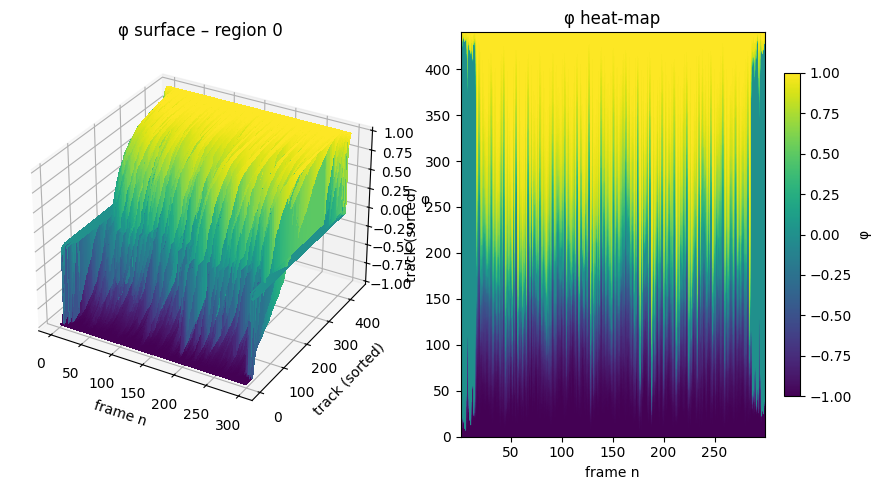

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D      # noqa: F401 – needed for 3-D

def compute_phi_matrix(db, region_idx=0):
    """Return a matrix  shape (P, T-2)  of φ values for the chosen region."""
    tracks_in_region = [tr for tr in db if tr['region'] == region_idx]
    if not tracks_in_region:
        raise ValueError(f"No tracks found for region {region_idx}")

    # All tracks have the same length by construction
    T = len(tracks_in_region[0]['rgb'])
    P = len(tracks_in_region)

    phi_mat = np.empty((P, T - 2), dtype=np.float32)

    for i, tr in enumerate(tracks_in_region):
        rgb = np.asarray(tr['rgb'], np.float32)
        v = np.diff(rgb, axis=0)            # (T-1, 3)

        v_prev, v_curr = v[:-1], v[1:]
        n_prev = np.linalg.norm(v_prev, axis=1) + 1e-12
        n_curr = np.linalg.norm(v_curr, axis=1) + 1e-12

        phi = np.sum(v_prev * v_curr, axis=1) / (n_prev * n_curr)   # length T-2
        phi_mat[i] = phi

    return phi_mat                 # P × (T-2)

def plot_phi_surface(phi_mat, title="φ surface", cmap="viridis"):
    """Sort φ column-wise and make a surface + heat-map."""
    # Column-wise sort (along tracks) to smooth the visual surface
    phi_sorted = np.sort(phi_mat, axis=0)   # still P × (T-2)

    P, Tm2 = phi_sorted.shape
    X, Y = np.meshgrid(np.arange(Tm2) + 1,    # frames 1 … T-2
                    np.arange(P))          # ordered tracks

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X, Y, phi_sorted, rstride=1, cstride=1, cmap=cmap,
                    linewidth=0, antialiased=False)
    ax.set_xlabel("frame n")
    ax.set_ylabel("track (sorted)")
    ax.set_zlabel("φ")
    ax.set_title(title)

    # 2-D heat-map (optional but handy)
    ax2 = fig.add_subplot(122)
    im = ax2.imshow(phi_sorted, aspect='auto', cmap=cmap,
                    origin='lower', extent=[1, Tm2, 0, P-1])
    ax2.set_xlabel("frame n")
    ax2.set_ylabel("track (sorted)")
    ax2.set_title("φ heat-map")
    fig.colorbar(im, ax=ax2, shrink=0.8, label="φ")

    plt.tight_layout()
    plt.savefig('/Users/henryschnieders/Desktop/phi_surface2.png', dpi=300)
    plt.show()

# ---------- demo ----------
region_idx = 0             # 0 = chin, 1 = mid-left cheek, 2 = mid-right cheek, 3 = left cheek, 4 = right cheek
phi_matrix = compute_phi_matrix(db, region_idx)
plot_phi_surface(phi_matrix, title=f"φ surface – region {region_idx}")


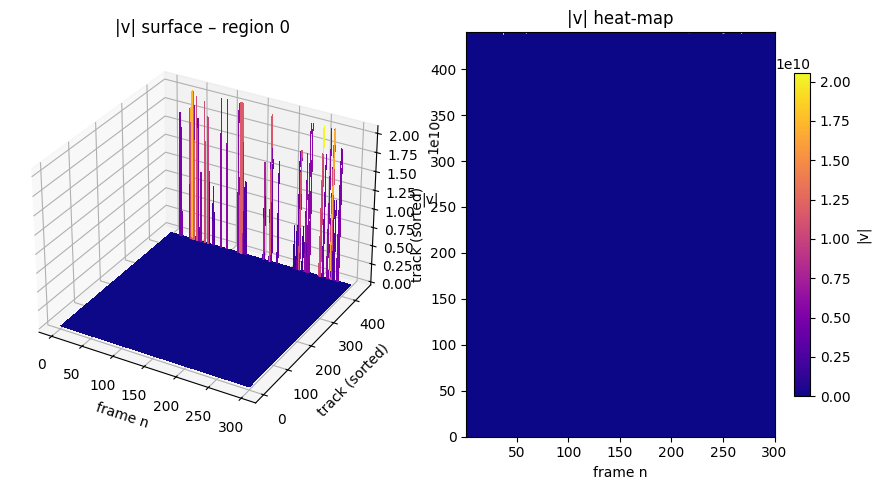

In [12]:
def compute_motion_mag_matrix(db, region_idx=0):
    """
    Return a matrix  shape (P, T-1)  whose (i, t) entry is the speed
    ‖Δrgb‖₂ of track i between frames t and t+1.
    """
    tracks_in_region = [tr for tr in db if tr['region'] == region_idx]
    if not tracks_in_region:
        raise ValueError(f"No tracks found for region {region_idx}")

    T = len(tracks_in_region[0]['rgb'])      # frames per track
    P = len(tracks_in_region)                # number of tracks

    mag_mat = np.empty((P, T - 1), dtype=np.float32)

    for i, tr in enumerate(tracks_in_region):
        rgb = np.asarray(tr['rgb'], np.float32)   # (T, 3)
        v   = np.diff(rgb, axis=0)                # (T-1, 3)
        mag_mat[i] = np.linalg.norm(v, axis=1)    # (T-1,)

    return mag_mat                                # P × (T-1)

def plot_motion_surface(mag_mat, title="|v| surface", cmap="plasma"):
    # Sort column-wise so ridges align nicely, exactly as for φ
    mag_sorted = np.sort(mag_mat, axis=0)

    P, Tm1 = mag_sorted.shape
    X, Y = np.meshgrid(np.arange(Tm1) + 1,     # frames 1 … T-1
                       np.arange(P))           # ordered tracks

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X, Y, mag_sorted, rstride=1, cstride=1,
                    cmap=cmap, linewidth=0, antialiased=False)
    ax.set_xlabel("frame n")
    ax.set_ylabel("track (sorted)")
    ax.set_zlabel("|v|")
    ax.set_title(title)

    # 2-D heat-map for quick inspection
    ax2 = fig.add_subplot(122)
    im = ax2.imshow(mag_sorted, aspect='auto', cmap=cmap,
                    origin='lower', extent=[1, Tm1, 0, P-1])
    ax2.set_xlabel("frame n")
    ax2.set_ylabel("track (sorted)")
    ax2.set_title("|v| heat-map")
    fig.colorbar(im, ax=ax2, shrink=0.8, label="|v|")

    plt.tight_layout()
    plt.savefig('/Users/henryschnieders/Desktop/motion_surface.png', dpi=300)
    plt.show()


region_idx = 0                      # 0 = chin, 1 = mid-L cheek, …
mag_matrix = compute_motion_mag_matrix(db, region_idx)
plot_motion_surface(mag_matrix,
                    title=f"|v| surface – region {region_idx}")


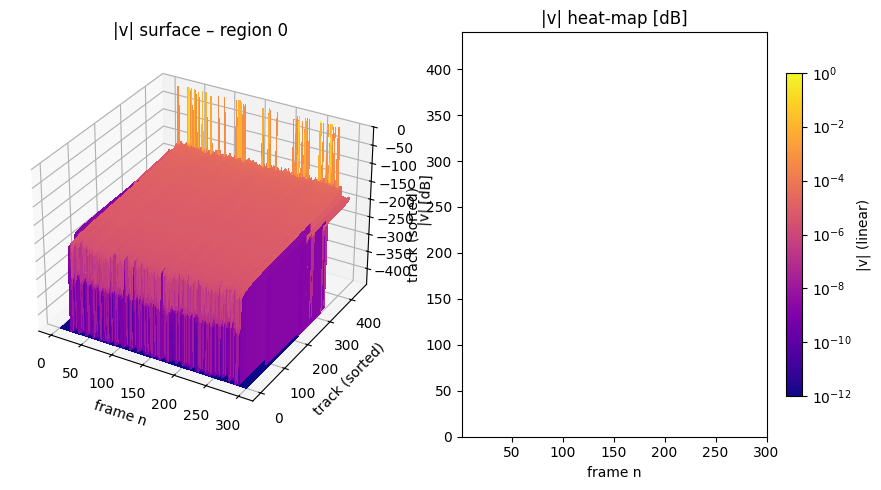

In [13]:
from matplotlib.colors import LogNorm

def plot_motion_surface(
        mag_mat,
        title="|v| surface (log-scaled)",
        cmap="plasma",
        ref="max",            # "max" → use global max as 0 dB reference
        eps=1e-12             # floor to avoid log(0)
):
    # ---------- 1.  normalise & log ----------
    if ref == "max":
        ref_val = mag_mat.max()
    elif np.isscalar(ref):
        ref_val = float(ref)
    else:
        raise ValueError("`ref` must be 'max' or a positive scalar")

    mag_db = 20.0 * np.log10((mag_mat + eps) / ref_val)   # dB, P×(T-1)
    mag_sorted = np.sort(mag_db, axis=0)

    # ---------- 2.  grids ----------
    P, Tm1 = mag_sorted.shape
    X, Y = np.meshgrid(np.arange(Tm1) + 1, np.arange(P))

    # ---------- 3.  plots ----------
    fig = plt.figure(figsize=(9, 5))

    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X, Y, mag_sorted, rstride=1, cstride=1,
                    cmap=cmap, linewidth=0, antialiased=False)
    ax.set_xlabel("frame n")
    ax.set_ylabel("track (sorted)")
    ax.set_zlabel("|v| [dB]")
    ax.set_title(title)
    ax.set_zlim(mag_sorted.min(), 0)          # 0 dB at top

    ax2 = fig.add_subplot(122)
    im = ax2.imshow(mag_sorted,
                    aspect='auto',
                    cmap=cmap,
                    origin='lower',
                    extent=[1, Tm1, 0, P-1],
                    norm=LogNorm(vmin=max(eps, 10**((mag_sorted.min())/20)),
                                 vmax=1))     # 0 dB ⇒ 1 (linear)
    ax2.set_xlabel("frame n")
    ax2.set_ylabel("track (sorted)")
    ax2.set_title("|v| heat-map [dB]")
    fig.colorbar(im, ax=ax2, shrink=0.8, label="|v| (linear)")

    plt.tight_layout()
    plt.savefig('/Users/henryschnieders/Desktop/motion_surface_log.png', dpi=300)
    plt.show()




region_idx = 0                      # 0 = chin, 1 = mid-L cheek, …
mag_matrix = compute_motion_mag_matrix(db, region_idx)
plot_motion_surface(mag_matrix,
                    title=f"|v| surface – region {region_idx}")


# Motion Process: v2

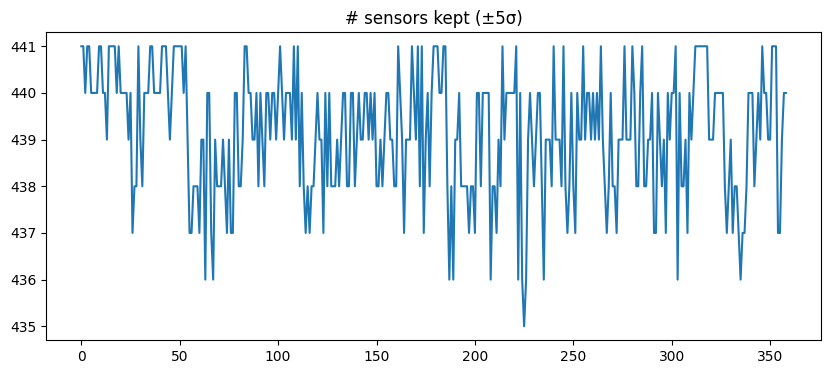

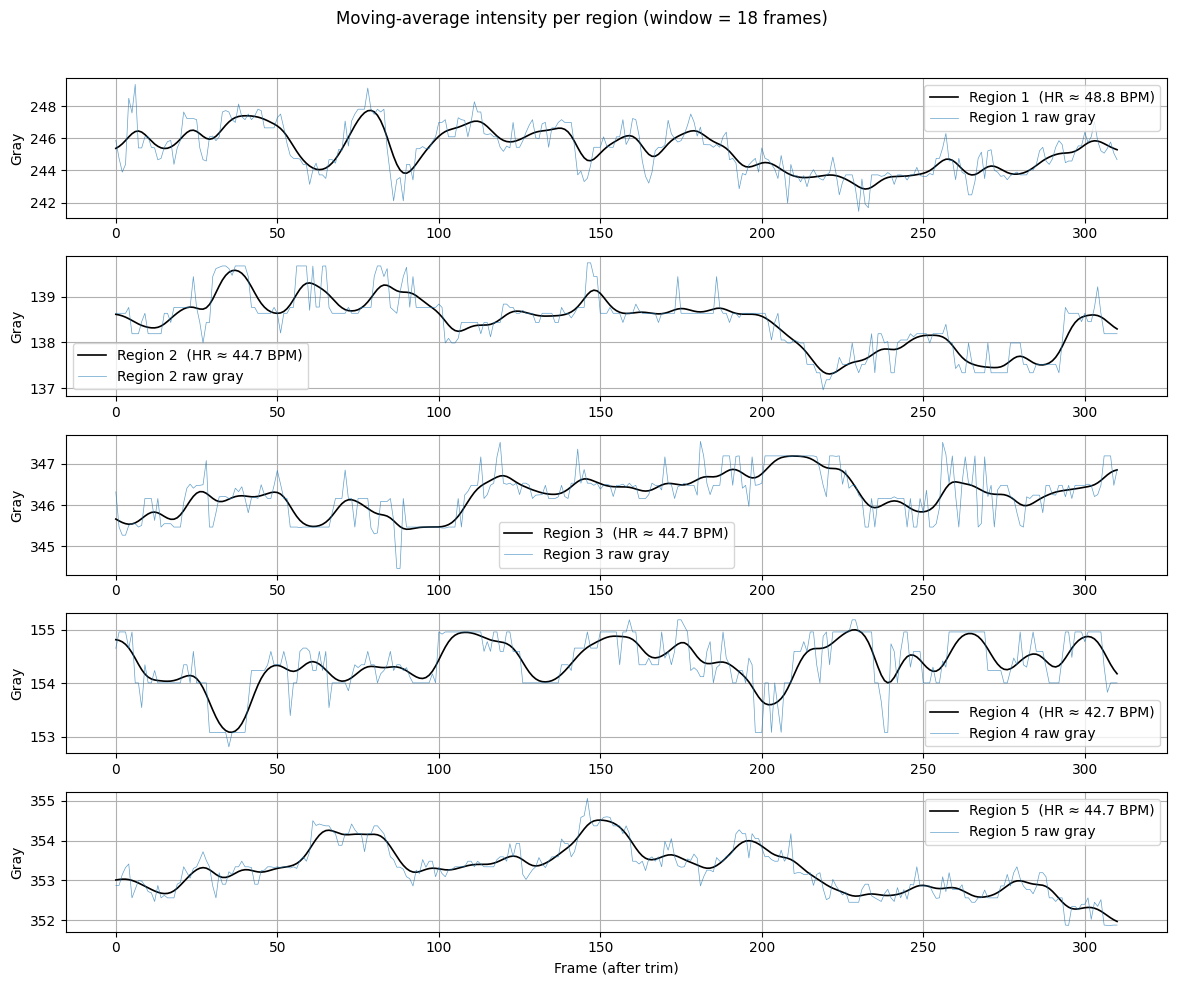

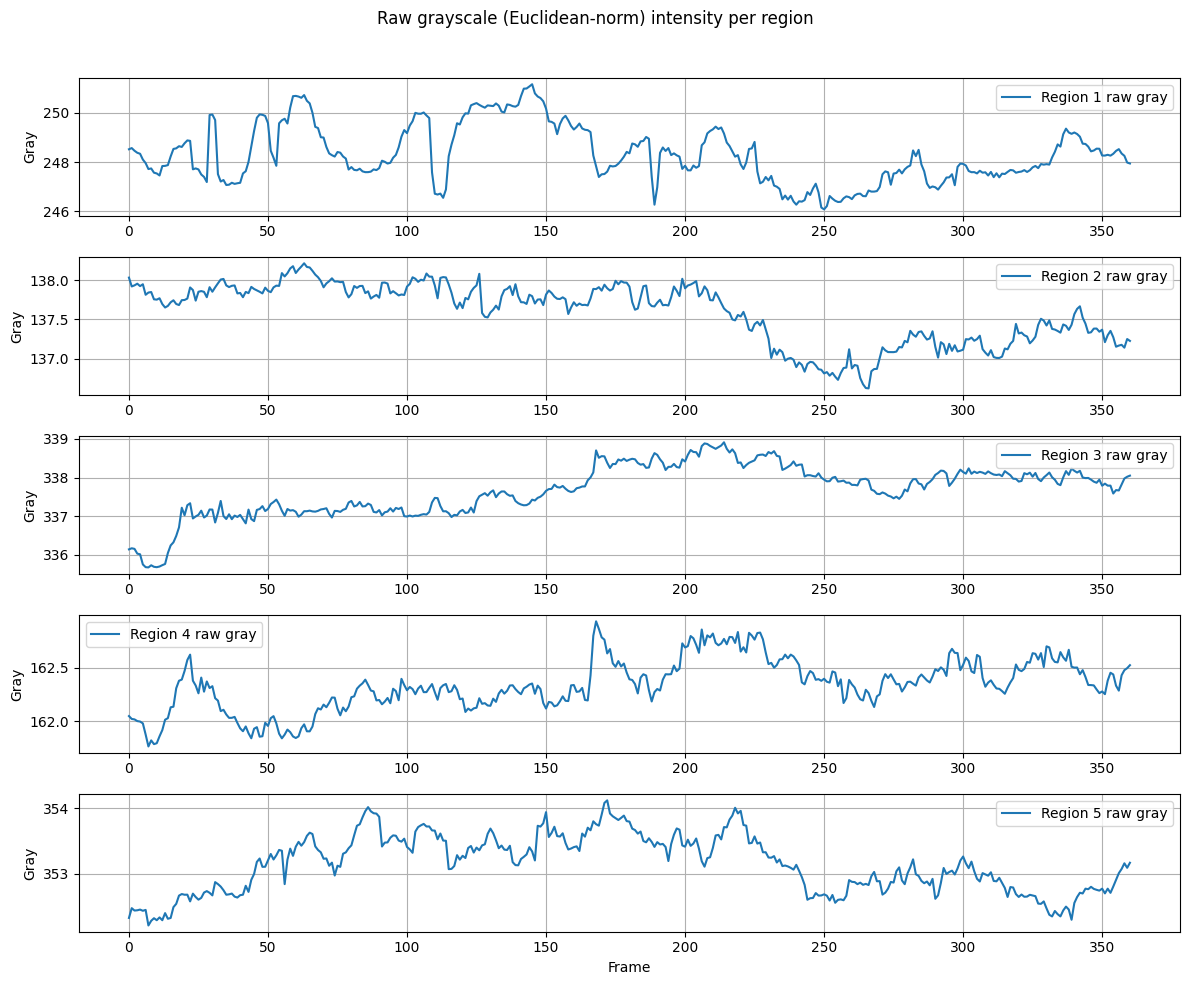

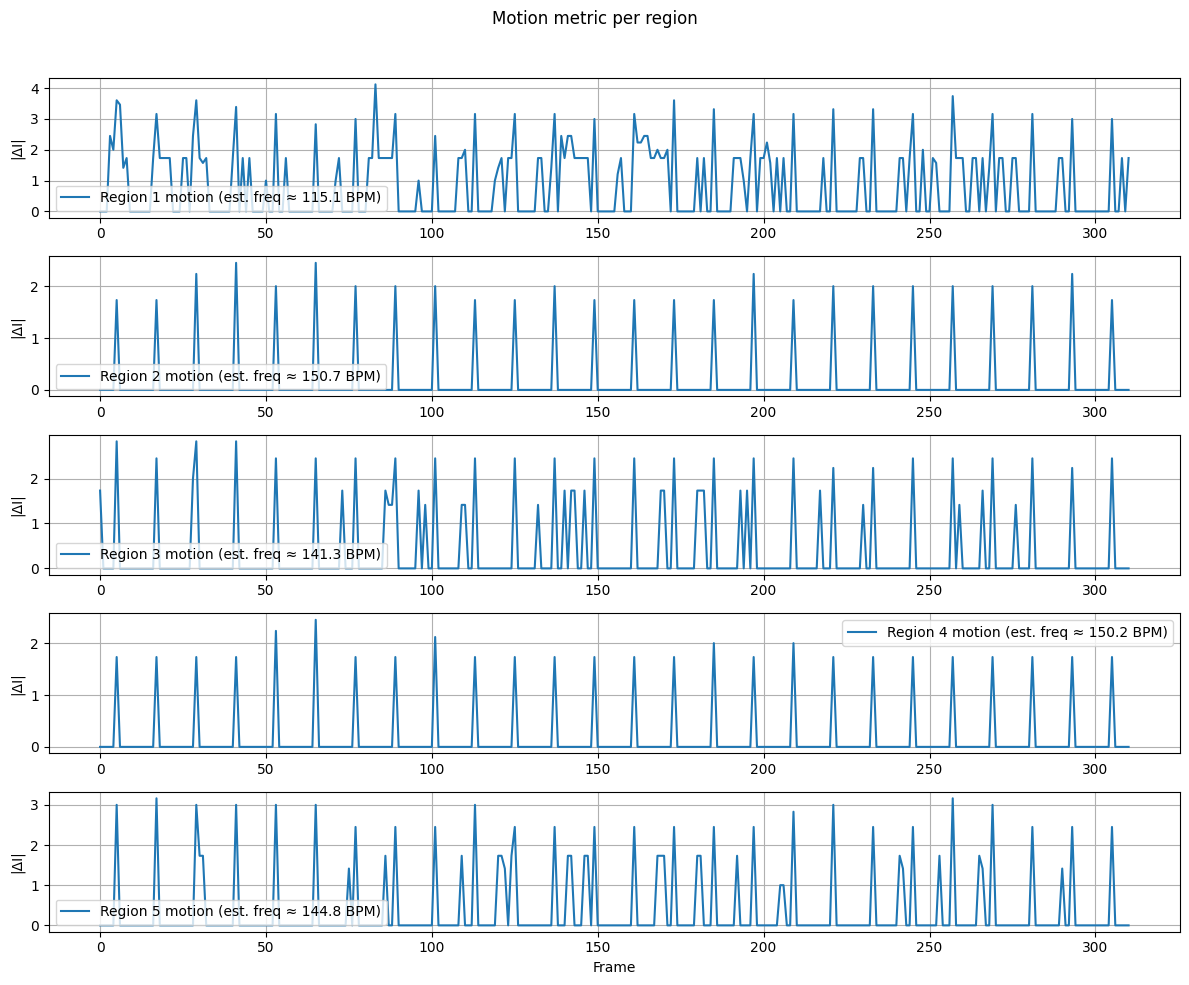

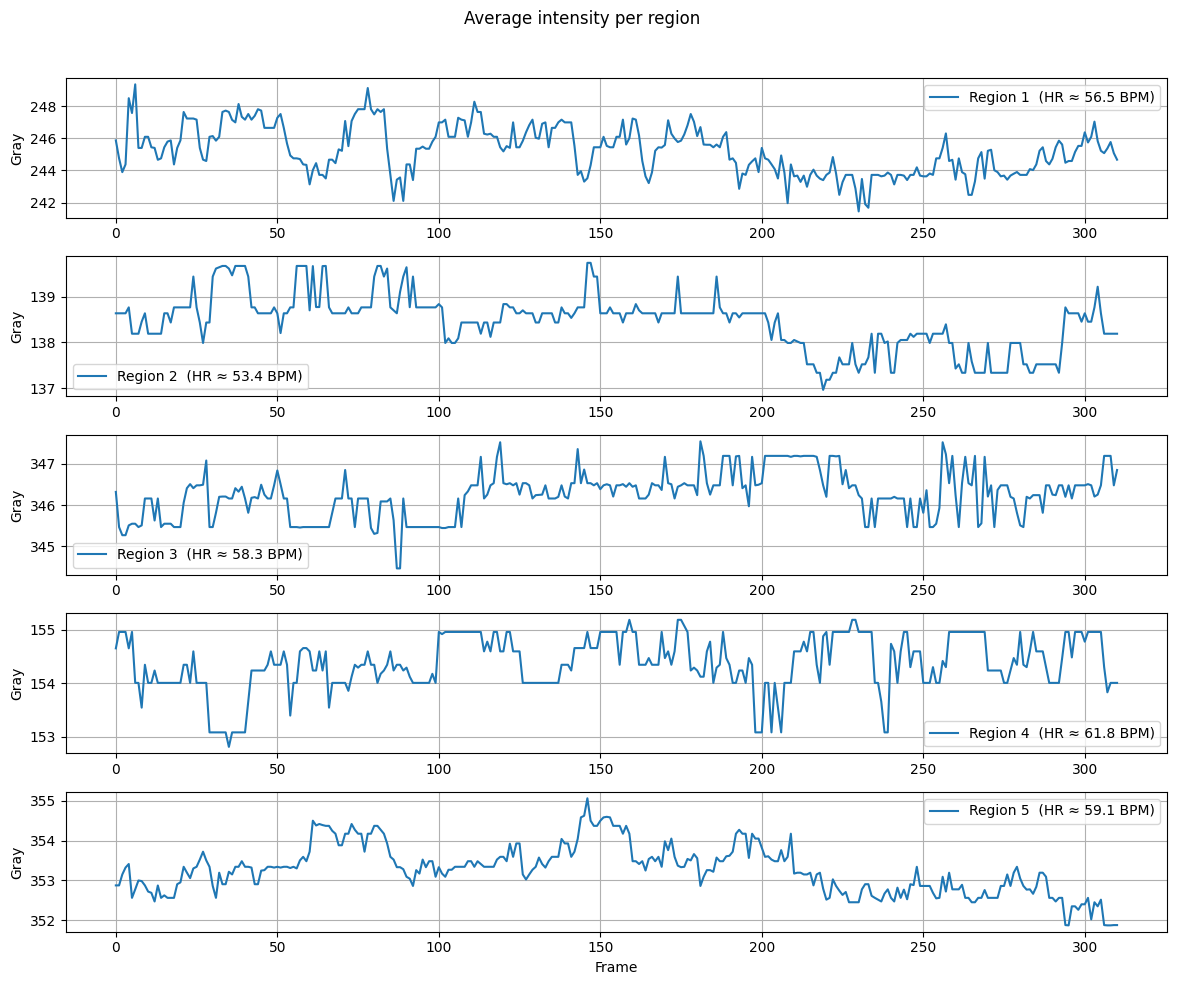

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# --------------------- configurable ---------------------
phi_tol      = 0.99         # cosine threshold
fps          = 30            # frames per second
n_regions    = 5             # chin, mid-L, mid-R, L, R
# --------------------------------------------------------

def build_gray(rgb_arr):
    """
    Return per-frame Euclidean norm ‖(R,G,B)‖₂.
    """
    rgb_arr = rgb_arr.astype(np.float32)
    return np.linalg.norm(rgb_arr, axis=1).astype(np.float32)

def process_tracks_motion_sigma(db,
                                n_regions,
                                std_thresh=5,      # “X σ” threshold
                                window_frac=0.10,  # sliding-window size for z-score normalisation
                                eps=1e-12):
    """
    Build region-level grey / RGB / motion signals after discarding, frame-by-frame,
    any track whose motion magnitude deviates more than `std_thresh` standard
    deviations from the region mean for that frame.

    Parameters
    ----------
    db : list of dict
        Your per-pixel track database (each item must have keys 'rgb', 'region', 'x0', 'y0').
    n_regions : int
        Number of distinct facial regions in the DB.
    std_thresh : float, optional
        Keep sensors with |mag − μ| ≤ std_thresh · σ.  Default = 3.
    window_frac : float, optional
        Fraction of track length used for centred sliding-window z-scoring.  Default = 0.10.
    eps : float, optional
        Small value to avoid division by zero.
    """
    # ---------- pass 1: per-track normalisation + motion magnitude ----------
    n_frames = len(db[0]['rgb'])
    window_size = max(1, int(len(db[0]['rgb']) * window_frac))
    half        = window_size // 2

    region_tracks, id_map = [[] for _ in range(n_regions)], [{} for _ in range(n_regions)]

    for tr in db:
        rgb_raw  = np.asarray(tr['rgb'], np.float32)              # (T,3)
        rgb_norm = np.empty_like(rgb_raw)
        T        = len(rgb_raw)

        # --- sliding-window z-score ---
        for t in range(T):
            start = max(0, min(t - half, T - window_size))
            window  = rgb_raw[start:start + window_size]
            mean    = window.mean(axis=0, keepdims=True)
            std     = window.std (axis=0, keepdims=True) + eps
            rgb_norm[t] = rgb_raw[t]

        # --- motion magnitude (between consecutive frames) ---
        motion      = np.diff(rgb_norm, axis=0)                   # (T-1, 3)
        motion_mag  = np.linalg.norm(motion, axis=1)              # (T-1,)

        track = dict(
            rgb        = rgb_norm,
            gray       = np.linalg.norm(rgb_norm, axis=1),        # (T,)
            motion_mag = motion_mag,                              # (T-1,)
            id         = f"x{tr['x0']}_y{tr['y0']}"
        )
        reg = tr['region']
        id_map[reg][track['id']] = len(region_tracks[reg])
        region_tracks[reg].append(track)

    # ---------- pass 2: region-level σ-filter & aggregation ----------
    region_signals, motion_signals, RGB_region_signals = [], [], []
    for reg in range(n_regions):
        P = len(region_tracks[reg])
        if P == 0:
            region_signals.append(np.full(n_frames, np.nan))
            motion_signals.append(np.full(n_frames, np.nan))
            RGB_region_signals.append(np.full((n_frames,3), np.nan))
            continue

        # matrices
        G      = np.stack([trk['gray']       for trk in region_tracks[reg]])   # P×T
        G_RGB  = np.stack([trk['rgb']        for trk in region_tracks[reg]])   # P×T×3
        M      = np.stack([trk['motion_mag'] for trk in region_tracks[reg]])   # P×(T-1)

        # --- σ-filter: keep sensors inside ± std_thresh σ for each (frame-1) ---
        mu    = M.mean(axis=0, keepdims=True)
        sigma = M.std (axis=0, keepdims=True) + eps
        MS    = (np.abs(M - mu) <= std_thresh * sigma).astype(np.uint8)   # P×(T-1)
        MS    = MS[:, 1:]                # align to frames 1…T-2  ⇒  P×(T-2)

        # ---------- aggregate with mask ----------
        sig      = np.zeros(n_frames, np.float32)
        RGB_sig  = np.zeros((n_frames, 3), np.float32)
        sig[0]   = np.median(G[:, 0])
        sig[-1]  = np.median(G[:, -1])
        RGB_sig[0]  = np.median(G_RGB[:, 0],  axis=0)
        RGB_sig[-1] = np.median(G_RGB[:, -1], axis=0)

        for t in range(1, n_frames - 1):            # frames 1 … T-2
            good           = MS[:, t - 1].astype(bool)
            sig[t]         = np.median(G[good, t])               if good.any() else np.nan
            RGB_sig[t]     = np.median(G_RGB[good, t], axis=0)   if good.any() else np.nan

        mot = np.zeros(n_frames, np.float32)
        mot[:] = np.nan          # undefined at frames 0 & T-1
        for t in range(1, n_frames - 1):
            good     = MS[:, t - 1].astype(bool)
            mot[t]   = np.median(M[good, t]) if good.any() else np.nan

        region_signals   .append(sig)
        motion_signals   .append(mot)
        RGB_region_signals.append(RGB_sig)

    # quick diagnostic: sensors kept per (region-last) frame
    good_per_frame = MS.sum(axis=0)          # shape (T-2,)
    plt.figure(figsize=(10, 4))
    plt.plot(good_per_frame)
    plt.title(f'# sensors kept (±{std_thresh}σ)')
    plt.show()

    return region_signals, motion_signals, id_map, RGB_region_signals



def norm_rgb_regions(rgb_regions, window_frac=0.10, eps=1e-8):
    """
    Sliding-window z-score per channel (R,G,B) for each region.
    `rgb_regions` is a list/ndarray of shape (N_regions, T, 3).

    Returns a *new* ndarray with the same shape, normalised.
    """
    normed = []
    for arr in rgb_regions:                      # arr: (T, 3)
        T   = arr.shape[0]
        win = max(1, int(round(T * window_frac)))
        half = win // 2
        out  = np.empty_like(arr, dtype=np.float32)

        for t in range(T):
            # centred window, clamped to [0, T-win]
            start = max(0, min(t - half, T - win))
            window = arr[start:start + win]
            mu  = window.mean(axis=0, keepdims=True)
            sd  = window.std (axis=0, keepdims=True) + eps
            out[t] = (arr[t] ) / mu
        normed.append(out)

    return np.stack(normed)                      # (N_regions, T, 3)



# -------------------- driver demo --------------------
if __name__ == "__main__":
    db = np.load('/Users/henryschnieders/Documents/Research/My_Data/pixel_trajectories_testagain_6_10_wholeface.npz', allow_pickle=True)['trajectories'].tolist()

    region_signals, motion_signals, id_map, RGB_region_signals = process_tracks_motion_sigma(db, n_regions= 5)


    # --- remove first and last frame from all signals because no mask for those frames -----------------
    cut = 25

    region_signals = [sig[cut:-cut] for sig in region_signals]
    motion_signals = [mot[cut:-cut] for mot in motion_signals]

        # --- NEW:  window-normalise each region’s RGB trace ----------------------
    RGB_region_signals = norm_rgb_regions(RGB_region_signals,  # ← just added
                                          window_frac=0.10)    # (10 % window)




    out_file  = "/Users/henryschnieders/Documents/Research/My_Data/rgb_per_region.npy"
    np.save(out_file, RGB_region_signals, allow_pickle=True)
    


    T_trim = len(region_signals[0])                      # after your `cut`
    win    = max(1, int(0.05 * (T_trim + 2*cut)))        # same 10 % rule
    sigma  = win / 6.0                                   # so ±3σ ~ window
    x      = np.arange(win) - win // 2
    kernel = np.exp(-0.5 * (x / sigma) ** 2)
    kernel = kernel / kernel.sum().astype(np.float32)    # normalise to 1.0

    gw_signals = []
    for sig in region_signals:
        ok       = ~np.isnan(sig)
        filled   = np.where(ok, sig, 0.0)
        w_sum    = np.convolve(filled, kernel, mode='same')      # weighted sum
        w_norm   = np.convolve(ok.astype(np.float32), kernel, mode='same')  # sum of weights that hit valid samples
        gw_mean  = np.where(w_norm > 0, w_sum / w_norm, np.nan)
        gw_signals.append(gw_mean)
        

    ma_signals = gw_signals  # use the Gaussian-weighted signals as moving average

    # ------------------ plot ------------------------------------------


    ma_freq_est = []
    for s in ma_signals:
        ok = ~np.isnan(s)
        bpm, _ = signal_process_alter(s[ok], fps) if ok.any() else (np.nan, [])
        ma_freq_est.append(bpm)




    plt.figure(figsize=(12, 10))
    for r, (orig, ma) in enumerate(zip(region_signals, ma_signals)):
        plt.subplot(5, 1, r + 1)
        plt.plot(ma,    lw=1.2, label=f"Region {r+1}  (HR ≈ {ma_freq_est[r]:.1f} BPM)", color='k')
        plt.plot(orig, lw=0.5, label=f"Region {r+1} raw gray", color='C0', alpha=0.7)
        plt.ylabel("Gray")
        plt.legend(); plt.grid(True)
        if r == 4:
            plt.xlabel("Frame (after trim)")
    plt.suptitle(f"Moving-average intensity per region (window = {win} frames)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('/Users/henryschnieders/Desktop/movavg_intensity_per_region.png', dpi=300)

    # --- estimate BPM: heart rate from polished signal -----------------
    hr_est = []
    for s in region_signals:
        ok = ~np.isnan(s)
        bpm, _ = signal_process_alter(s[ok], fps) if ok.any() else (np.nan, [])
        hr_est.append(bpm)


    #------ estimate frequency: motion data -----------

    freq_est = []
    for s in motion_signals:
        ok = ~np.isnan(s)
        bpm, _ = signal_process_alter(s[ok], fps, num = 5) if ok.any() else (np.nan, [])
        freq_est.append(bpm)


    # ---------- Raw grayscale per region ----------
    raw_signals = []
    T = len(db[0]['rgb'])
    for reg in range(n_regions):
        tracks = [
            build_gray(np.asarray(tr['rgb'], np.float32))
            for tr in db if tr['region'] == reg
        ]
        raw_signals.append(np.mean(tracks, axis=0) if tracks else np.full(T, np.nan))

    # # ---------- Normal pipeline ----------
    # region_signals, motion_signals, id_map = process_tracks_with_phi(db, phi_tol=0.95)

    # ---------- Plot 0: raw grayscale intensity ----------
    plt.figure(figsize=(12, 10))
    for r, sig in enumerate(raw_signals):
        plt.subplot(5, 1, r + 1)
        plt.plot(sig, label=f"Region {r + 1} raw gray")
        plt.ylabel("Gray")
        plt.legend()
        plt.grid(True)
        if r == 4:
            plt.xlabel("Frame")
    plt.suptitle("Raw grayscale (Euclidean‐norm) intensity per region")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('/Users/henryschnieders/Desktop/raw_grayscale_per_region.png', dpi=300)

    # --------- Plot 1: motion ----------
    plt.figure(figsize=(12,10))
    for r, mot in enumerate(motion_signals):
        plt.subplot(5,1,r+1)

        plt.plot(mot, label=f"Region {r+1} motion (est. freq ≈ {freq_est[r]:.1f} BPM)")
        plt.ylabel("|ΔI|")
        plt.legend(); plt.grid(True)
        if r==4: plt.xlabel("Frame")
    plt.suptitle("Motion metric per region"); plt.tight_layout(rect=[0,0,1,0.96])
    plt.savefig('/Users/henryschnieders/Desktop/motion_per_region.png', dpi=300)

    # --------- Plot 2: intensity -------
    plt.figure(figsize=(12,10))
    for r, sig in enumerate(region_signals):
        plt.subplot(5,1,r+1)
        plt.plot(sig, label=f"Region {r+1}  (HR ≈ {hr_est[r]:.1f} BPM)")
        plt.ylabel("Gray")
        plt.legend(); plt.grid(True)
        if r==4: plt.xlabel("Frame")
    plt.suptitle("Average intensity per region"); plt.tight_layout(rect=[0,0,1,0.96])
    plt.savefig('/Users/henryschnieders/Desktop/avg_intensity_per_region.png', dpi=300)
    plt.show()

    # lookup example
    who = "x250_y180"
    for r in range(n_regions):
        if who in id_map[r]:
            print(f"{who} is track {id_map[r][who]} in region {r+1}")



In [3]:
import numpy as np

pix_trajectories = '/Users/henryschnieders/Documents/Research/My_Data/pixel_trajectories_20250610_173607.npz'

In [19]:
db = np.load(pix_trajectories, allow_pickle=True)['trajectories'].tolist()

print(len(db[0]['rgb']))
print(np.array(db[0]['rgb']))

361
[[ 86  97 122]
 [ 84  96 120]
 [ 84  96 119]
 ...
 [ 79  90 115]
 [ 79  90 115]
 [ 79  90 115]]


In [14]:
def build_gray(rgb_arr):
    """
    Return per-frame Euclidean norm ‖(R,G,B)‖₂.
    """
    rgb_arr = rgb_arr.astype(np.float32)
    return np.linalg.norm(rgb_arr, axis=1).astype(np.float32)

In [16]:
print(build_gray(np.array(db[0]['rgb'])))

[178.01404 175.13423 174.45056 174.45056 172.7368  172.7368  172.7368
 169.31036 169.31036 169.31036 169.31036 169.31036 169.31036 171.02339
 171.02339 171.02339 171.02339 169.31036 168.91714 170.62825 172.33978
 172.33978 172.33978 172.33978 172.33978 170.62825 170.62825 170.62825
 168.91714 178.71765 178.71765 179.0447  174.45056 172.7368  172.7368
 172.7368  172.7368  174.45056 172.7368  172.7368  172.7368  172.7368
 172.7368  179.72757 179.72757 181.30913 179.0447  181.30913 181.30913
 179.0447  176.64937 181.30913 181.30913 179.0447  169.31036 173.42145
 175.13423 175.13423 175.13423 175.13423 175.13423 175.13423 175.13423
 175.13423 175.13423 175.13423 175.13423 173.02602 171.3155  171.3155
 171.3155  169.60542 169.60542 169.60542 169.60542 169.60542 169.60542
 169.60542 169.60542 168.91714 168.91714 168.91714 168.91714 168.91714
 166.74231 166.74231 166.74231 163.78645 163.78645 163.78645 163.78645
 166.74231 166.74231 166.74231 166.74231 166.74231 166.74231 163.78645
 163.78645

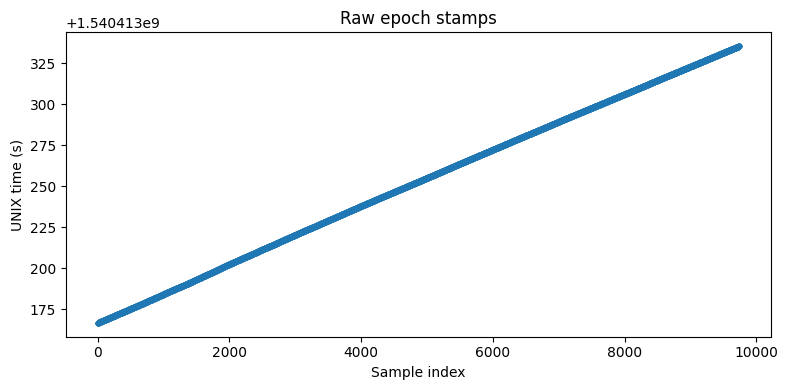

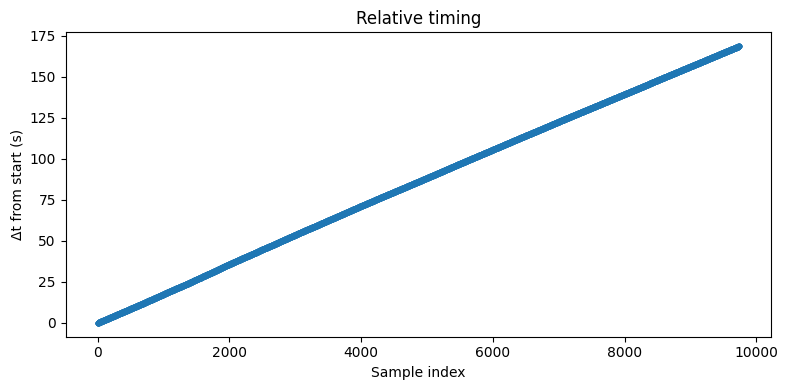

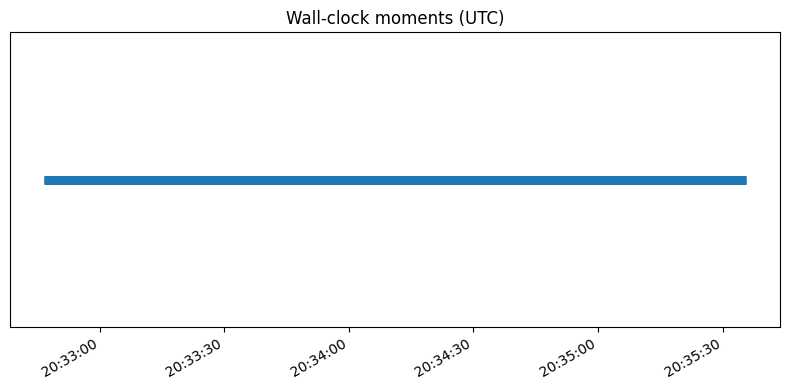

In [7]:
import numpy as np


#/Users/henryschnieders/Downloads/subject1_driving_large_motion_975/PulseOx/cam0_full_log.txt

# Open the pulse oximeter log file
pulse_ox_file = '/Users/henryschnieders/Downloads/subject1_driving_large_motion_975/PulseOx/cam0_full_log.txt'

# 01 ------------- imports ------------------------------------------------------
import ast                               # safe literal-string → Python object
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone   # only needed for “wall-clock” plot

# 02 ------------- load the raw string -----------------------------------------
with open(pulse_ox_file, "r") as f:    # ← replace with your file path
    raw = f.read().strip()

# 03 ------------- string → list[float] ----------------------------------------
ts = np.array(ast.literal_eval(raw), dtype=float)   # UNIX-epoch seconds

# 04 ------------- quick plot: index vs time -----------------------------------
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(ts)), ts, ".-")
plt.xlabel("Sample index")
plt.ylabel("UNIX time (s)")
plt.title("Raw epoch stamps")
plt.tight_layout()
plt.show()

# 05 ------------- optional: time-since-start plot -----------------------------
t_rel = ts - ts[0]                        # seconds since first stamp
plt.figure(figsize=(8, 4))
plt.plot(t_rel, ".-")
plt.xlabel("Sample index")
plt.ylabel("Δt from start (s)")
plt.title("Relative timing")
plt.tight_layout()
plt.show()

# 06 ------------- optional: wall-clock stamps on the x-axis -------------------
dt = [datetime.fromtimestamp(t, tz=timezone.utc) for t in ts]
plt.figure(figsize=(8, 4))
plt.plot(dt, np.zeros_like(ts), "|")      # draw vertical ticks at each stamp
plt.gcf().autofmt_xdate()
plt.yticks([])
plt.title("Wall-clock moments (UTC)")
plt.tight_layout()
plt.show()


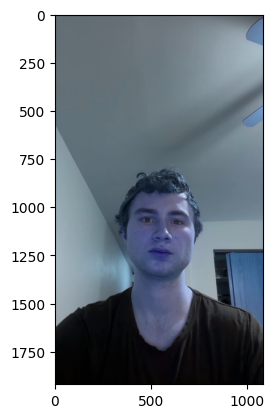

In [4]:
import numpy as np
import matplotlib.pyplot as plt


data = np.load('/Users/henryschnieders/Documents/Research/My_Data/mornin_6_16_wholeface.npy', allow_pickle=True)


img = data[0]

plt.imshow(img)

In [ ]:
import cv2, mediapipe as mp, numpy as np

# ---------- 1. init once ----------
fm        = mp.solutions.face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            refine_landmarks=True,      # gets iris too
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5)
 
 # pre-cached landmark index groups (CF. Nature 2024 S44328-024-00002-1)
ROI_IDXS = dict(
    forehead = [10, 67, 297, 336, 338, 151, 299, 9],   # convex hull gives full patch
    l_cheek  = [234, 93, 132, 58, 172, 136, 150],
    r_cheek  = [454, 323, 361, 288, 397, 365, 379])

def adaptive_rois(frame_bgr, grid_side=9, grid_pitch=2):
    """Return (roi_masks, seeds) for the current frame."""
    h, w, _ = frame_bgr.shape
    frame_rgb   = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    results     = fm.process(frame_rgb)
    if not results.multi_face_landmarks:
        raise RuntimeError("No face found")

    lm = results.multi_face_landmarks[0].landmark
    lm_xy = np.array([(p.x*w, p.y*h) for p in lm], dtype=np.float32)

    roi_masks, seeds = [], []
    for key, idxs in ROI_IDXS.items():
        poly   = lm_xy[idxs].astype(np.int32)
        mask   = np.zeros((h, w), np.uint8)
        cv2.fillConvexPoly(mask, poly, 1)
        roi_masks.append(mask.astype(bool))

        # --- make dense seed grid inside the ROI -----------------
        ys, xs = np.where(mask)
        if len(xs) == 0:                # occluded / off-screen
            seeds.append(np.empty((0, 2), np.float32));  continue
        xmin, xmax = xs.min(), xs.max()
        ymin, ymax = ys.min(), ys.max()
        xs_grid = np.arange(xmin, xmax+1, grid_pitch)
        ys_grid = np.arange(ymin, ymax+1, grid_pitch)
        xv, yv  = np.meshgrid(xs_grid, ys_grid)
        pts     = np.column_stack([xv.ravel(), yv.ravel()]).astype(np.float32)
        inside  = mask[pts[:,1].astype(int), pts[:,0].astype(int)]
        seeds.append(pts[inside][:grid_side**2])   # cap count like before

    return roi_masks, seeds